In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.io.wavfile import write, read
from scipy.io import wavfile
import math
from time import sleep
from playsound import playsound
from math import floor

In [13]:
import pyaudio
import wave
filename = "recorded.wav"
chunk = 1024
FORMAT = pyaudio.paInt16
channels = 1
sample_rate = 44100
record_seconds = 15
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=channels,
                rate=sample_rate,
                input=True,
                output=True,
                frames_per_buffer=chunk)
frames = []
print("Recording")
for i in range(int(sample_rate / chunk * record_seconds)):
data = stream.read(chunk)
frames.append(data)
stream.stop_stream()
stream.close()
p.terminate()
wf = wave.open(filename, "wb")
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(sample_rate)
wf.writeframes(b"".join(frames))
wf.close()

TypeError: 'numpy.ndarray' object is not callable

In [2]:
#Генерация синусоиды с заданными параметрами
SAMPLE_RATE = 44100  # Гц - частота дискретизации

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, int(sample_rate*duration), endpoint=False)
    frequencies = x * freq
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

def signal_modulation(text, freq0, freq1, sample_rate, change_time): #Сама частотная модуляция. Эта часть будет дорабатываться, пока что тут только две частоты(тупо складываем синусоиды двух частот)
    duration = change_time * len(text)
    num = int(duration / change_time)
    time = np.array([], dtype = np.int16)
    signal = np.array([], dtype = np.int16)
    for i in range(num):
        if text[i] == "0":
            freq = freq0
        if text[i] == "1":
            freq = freq1
        time_diff, data = generate_sine_wave(freq, sample_rate, change_time)
        signal = np.concatenate((signal, data), axis = None)
        time = np.concatenate((time, time_diff), axis = None)
    return time, signal

#Достаем массив данных и частоту дискретизации из файла со звуком
def wav_data_x_sample_rate(filename):
    sample_rate, data = wavfile.read(filename)
    duration = len(data) / sample_rate 
    return data, sample_rate

In [12]:
#Здесь меняем параметры для дальнейшего тестирования
CHANGE_TIME = 0.5   
FREQ1 = 1000
FREQ2 = 2000
TEXT = "10101111000"
DURATION = len(TEXT) * CHANGE_TIME
x, tone_ex = signal_modulation(TEXT, FREQ1, FREQ2, SAMPLE_RATE, CHANGE_TIME)
write("tone_ex", SAMPLE_RATE, tone_ex)
len(TEXT)

11

In [4]:
#Сам декодеровщик: самая ненадежная и нуждающаяся в доработке часть
def decoder(data, sample_rate, duration, change_time, freq0, freq1):
    code = ""
    num = int(duration / change_time)
    print(num)
    signal = secure_split(data, num)
    for i in range(num):
        yf = rfft(signal[i])
        xf = rfftfreq(len(signal[i]), 1 / sample_rate)
        abs_power = np.abs(yf)
        max_power = np.max(abs_power)
        index = np.where(abs_power == max_power)
        freq = xf[index]
        print(freq)
        if np.isclose(freq, freq1, atol = 10):
            code += "1"
        if np.isclose(freq, freq0, atol = 10):
            code += "0"
    return code

def fourier_abs(data, sample_rate):
    duration = int(len(data) / sample_rate)
    xf = rfftfreq(len(data), 1 / sample_rate)
    yf = rfft(data)
    yf = yf.flatten()
    return np.array([xf, np.abs(yf)])

def index_of_freq(xf, freq, range_index):
    index = np.where(np.isclose(xf, freq, atol = range_index))[0][0]
    return index

def get_index_start_end_of_longest_ones(lt):
   m = 0
   index = 0
   cnt = 0
   end_index = 0
   for i in range(len(lt)):
     a = bool(lt[i])
     if a:
       cnt += 1
     if not a:
       if cnt > m:
         m = cnt
         index = i - cnt
         end_index = index + cnt -1
         length = end_index - index + 1
       cnt = 0
   if cnt > m:
     index = i + 1 - cnt
   return index, end_index, length

def fourier_for_array(data_array, sample_rate):
  _, ans = fourier_abs(data_array[0], sample_rate)
  ans = [ans]
  for i in range(1, len(data_array)):
    data_window = data_array[i]
    xf_for_array, yf_window = fourier_abs(data_window, sample_rate)
    ans = np.concatenate((ans, [yf_window]), axis = 0)
  return xf_for_array, ans

def abs_diff(yf_window, xf, freq0, freq1, range_index):
  absolute_difference = abs(yf_window[index_of_freq(xf, freq0, range_index)] - yf_window[index_of_freq(xf, freq1, range_index)]) ** 2
  return absolute_difference

def calc_function(yf_array, freq0, freq1, xf, range_index):
  func = 0
  for i in range(len(yf_array)):
    yf_window = yf_array[i]
    func += abs_diff(yf_window, xf, freq0, freq1, range_index)
  return func

def make_step(definite_sound_array):
   step = len(definite_sound_array) * 0.0001
   return int(step)
   

def plotting_function(definite_yf_array, definite_sound_array, supposed_sound_array, freq0, freq1, xf, range_index, N, sample_rate):
   number_of_steps = 0
   y_array = np.array([], dtype = float)
   step = make_step(definite_sound_array)
   x_array= np.array([], dtype = float)
   while int(step * number_of_steps) + len(supposed_sound_array) + step < len(definite_sound_array) - 1 - step:
      xf, yf_array, changed_sound_array = apply_step(definite_sound_array, supposed_sound_array, N, step, number_of_steps, sample_rate)
      func = calc_function(yf_array, freq0, freq1, xf, range_index)
      y_array = np.concatenate((y_array, [func]), axis = None)
      step = make_step(definite_sound_array)
      supposed_sound_array = changed_sound_array
      x_array = np.concatenate((x_array, [number_of_steps]), axis = None)
      number_of_steps += 1
   plt.plot(y_array)
   return x_array, y_array, supposed_sound_array
  


def secure_split(array, N):
   if len(array) % N !=0:
     array = np.concatenate((array, np.zeros(N - len(array) % N)), axis = None)
   array = np.split(array, N)
   l = np.shape(array)
   if len(l) == 3:
      array = np.reshape(array, (l[0], l[1]))
   return np.array(array)

def make_fourier_array(sound_data, sample_rate, N):
   data_array = secure_split(sound_data, N)
   x, f_array = fourier_for_array(data_array, sample_rate)
   return x, f_array
   
        
def apply_step(definite_sound_array, supposed_sound_array, N, step, number_of_steps, sample_rate):
   
   changed_sound_array = definite_sound_array[int(step * number_of_steps + step):int(step * number_of_steps + len(supposed_sound_array) + step)]
   changed_sound_data_array = secure_split(changed_sound_array, N)
   xf, changed_yf_array = fourier_for_array(changed_sound_data_array, sample_rate)
   return xf, changed_yf_array, changed_sound_array

In [5]:
def decoder_1(data, sample_rate, change_time, freq0, freq1):
  duration = floor(len(data) / sample_rate)      #whole time
  N0 = int(duration / change_time)        #number of windows
  data = np.concatenate((data, np.zeros(N0 - len(data) % N0)), axis = None)
  data_array = np.split(data, N0)         #array of arrays with sound data
  range_index = 5                         #range within which we get freq indexes
  xf_whole, yf_whole = fourier_abs(data, sample_rate) #fourier transform for whole signal
  freq0_index, freq1_index = index_of_freq(xf_whole, freq0, range_index), index_of_freq(xf_whole, freq1, range_index)
  max_yf = yf_whole[freq0_index] + yf_whole[freq1_index]
  threshold_yf = max_yf / 5               #any cell with amplitude below this is def not a signal
  xf_for_array, yf_array = fourier_for_array(data_array, sample_rate)
  yf_for_array_bool = np.zeros(len(yf_array), dtype = bool) #array that shows whether the signal might be there
  for i in range(len(yf_array)): #filling it in
    yf = yf_array[i]
    current_yf = yf[index_of_freq(xf_for_array, freq0, range_index)] + yf[index_of_freq(xf_for_array, freq1, range_index)]
    if current_yf > threshold_yf:
      yf_for_array_bool[i] = True
  rough_beginning_index, rough_end_index, N = get_index_start_end_of_longest_ones(yf_for_array_bool)#index where signal  starts (rough estimation)
  index_signal_left, index_signal_right = rough_beginning_index - 1, rough_end_index + 1 #sin waves DEFINETELY are within these indexes
  definite_yf_array = yf_array[index_signal_left:index_signal_right + 1] #sin waves should be found here
  definite_sound_array = np.reshape(data_array[index_signal_left:index_signal_right+1], (np.shape(data_array[index_signal_left:index_signal_right+1])[0] * np.shape(data_array[index_signal_left:index_signal_right])[1], 1)) #normal form of sound
  supposed_sound_array  = np.reshape(data_array[index_signal_left + 1:index_signal_right], (np.shape(data_array[index_signal_left + 1:index_signal_right])[0] * np.shape(data_array[index_signal_left + 1:index_signal_right - 1])[1], 1)) #normal form of sound
  numba, ar, actual_sound_data = plotting_function(definite_yf_array, definite_sound_array, supposed_sound_array, freq0, freq1, xf_for_array, range_index, N, sample_rate)
  actual_sound_data_array = secure_split(actual_sound_data, N)
  actual_xf, actual_yf = fourier_for_array(actual_sound_data_array, sample_rate)

  return yf_for_array_bool, actual_sound_data, actual_xf, actual_yf
  



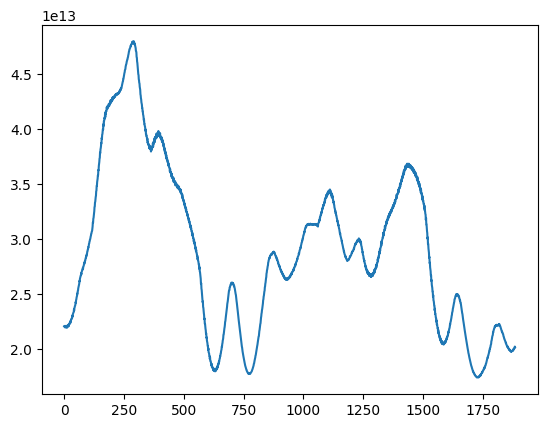

In [6]:
data, _ = wav_data_x_sample_rate("recorded.wav")
change_time = 0.5
bool, sound, xf, yf = decoder_1(data, SAMPLE_RATE, change_time, FREQ1, FREQ2)

In [7]:
bool

array([False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [8]:
np.shape(yf)

(9, 11795)

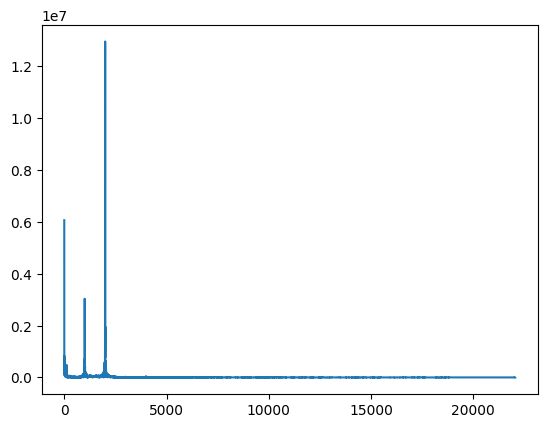

In [10]:
plt.plot(xf, yf[0])

In [11]:
m = np.max(ar)
mi = np.min(ar)
index = np.where(ar == m)[0][0]
plt.plot(ar[index- 100:index + 100])
m

NameError: name 'ar' is not defined

In [ ]:
m = np.max(ar)
mi = np.min(ar)
index = np.where(ar == m)[0][0]
val = int(numba[index])
h = spsd[val]
m_index = int(h * step)
ayo = spsd[m_index:m_index + len(spsd)]
plt.plot(ayo)

In [10]:
decoder(sound, SAMPLE_RATE, DURATION, change_time, FREQ1, FREQ2)

11
[997.36535323]
[1999.87176498]
[1999.87176498]
[997.36535323]
[997.36535323]
[997.36535323]
[1999.87176498]
[1999.87176498]
[1999.87176498]
[1999.87176498]
[1999.87176498]


'01100011111'

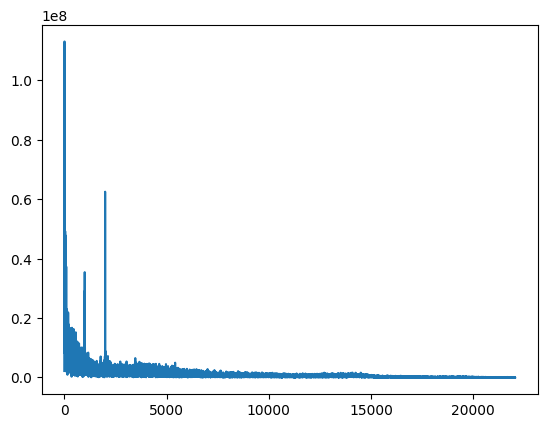

In [54]:
data, _ = wav_data_x_sample_rate("recorded.wav")


In [ ]:
start_function = calc_function(definite_yf_array, freq0, freq1, xf_for_definite_array, range_index)

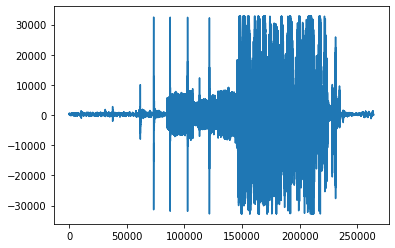

In [180]:
plt.plot(data[int(0*change_time * sample_rate):int(len(data_array)*change_time * sample_rate)])

In [37]:
xf_whole, yf_whole = fourier_abs(data, SAMPLE_RATE)
freq0_index, freq1_index = index_of_freq(xf_whole, 1000, 5), index_of_freq(xf_whole, 2000, 5)
max_yf = yf_whole[freq0_index] + yf_whole[freq1_index]
max_yf

17886361.52361161

3.0
3


ValueError: ignored

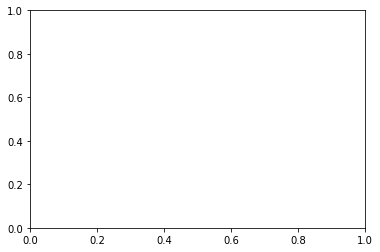

In [43]:
a = np.array([1,2])
b = np.abs(np.fft.rfftn(tone_ex))
x = x.astype(int)
print(len(tone_ex) / SAMPLE_RATE)
d = int(len(tone_ex) / SAMPLE_RATE)
print(d)
plt.plot(np.fft.fftfreq(len(tone_ex)), rfft(tone_ex))


In [ ]:
def find_beginning(data, duration, sample_rate, freq0, freq1):
    xf_whole, yf_whole = fourier_abs(data, sample_rate)
    freq0_index, freq1_index = index_of_freq(xf_whole, freq0), index_of_freq(xf_whole, freq1)
    max_freq = yf_whole[freq0_index] + yf_whole[freq1_index]
    target_index = int(len(data) / 2)
    timepoints_of_sin = int(sample_rate * duration)
    print(timepoints_of_sin)
    timepoint_shift = int(timepoints_of_sin / 2)
    xf, yf = fourier_abs(data[int(target_index - timepoints_of_sin / 2):int(target_index + timepoints_of_sin / 2)], sample_rate)
    freq0_index, freq1_index = index_of_freq(xf, freq0), index_of_freq(xf, freq1)
    freq_sum = yf[freq0_index] + yf[freq1_index]
    i = 0
    target_index_right = int(target_index + timepoint_shift)
    target_index_left = int(target_index - timepoint_shift)
    while not (math.isclose(max_freq, freq_sum, abs_tol = 100)):
        if target_index_left <= int(timepoints_of_sin / 2):
            target_index_left = int(timepoints_of_sin / 2)
        if int(target_index_right + timepoints_of_sin / 2) >= len(data):
            target_index_right = int(len(data) - timepoints_of_sin / 2)
        xf_l, yf_l = fourier_abs(data[int(target_index_left - timepoints_of_sin / 2):int(target_index_left + timepoints_of_sin / 2)], sample_rate)
        xf_r, yf_r = fourier_abs(data[int(target_index_right - timepoints_of_sin / 2):int(target_index_right + timepoints_of_sin / 2)], sample_rate)
        freq0_index_l, freq1_index_l, freq0_index_r, freq1_index_r = index_of_freq(xf_l, freq0), index_of_freq(xf_l, freq1), index_of_freq(xf_r, freq0), index_of_freq(xf_r, freq1)
        freq_sum_r , freq_sum_l= yf_r[freq0_index] + yf_r[freq1_index], yf_l[freq0_index] + yf_l[freq1_index]    
        print(freq_sum_l, freq_sum_r, freq_sum, max_freq, timepoint_shift)   
        if freq_sum_r >= freq_sum:
            if freq_sum < max_freq:
              target_index = target_index_right
              freq_sum = freq_sum_r
            else:
                target_index = target_index_left
                freq_sum = freq_sum_l
        if freq_sum_l > freq_sum:
            if freq_sum < max_freq:
              target_index = target_index_left
              freq_sum = freq_sum_l
            else:
                target_index = target_index_right
                freq_sum = freq_sum_r
        if freq_sum_l < freq_sum and freq_sum_r < freq_sum:
            freq_sum = max(freq_sum_r, freq_sum_l)
            if freq_sum == freq_sum_l:
                target_index = target_index_left
            else:
                target_index = target_index_right
        timepoint_shift = int(timepoint_shift / 2)
        target_index_left = int(target_index - timepoint_shift)
        target_index_right = int(target_index + timepoint_shift)
        if math.isclose(timepoint_shift, 0, abs_tol = 1):
            i += 1
            timepoint_shift = timepoints_of_sin / (2 * i)
        if target_index_left == target_index_right:
            break
    
    print("target_index", target_index)
    data_beginning = data[int(target_index - timepoints_of_sin / 2):int(target_index + timepoints_of_sin/2)]
    return data_beginning


        



132300
43739891.34727153 199808917.46803156 184672678.02771926 218783134.17876 66150
268685491.04198915 199808917.46803156 199808917.46803156 218783134.17876 33075
265150031.94732475 202648125.8985793 268685491.04198915 218783134.17876 16537
240379226.57743606 264035856.93442276 265150031.94732475 218783134.17876 8268
263929761.23453096 265597705.76610386 264035856.93442276 218783134.17876 4134
264348382.83046308 263834460.48947462 263929761.23453096 218783134.17876 2067
263812906.7450087 263870456.67297176 263834460.48947462 218783134.17876 1033
263903427.15449935 263774155.06845155 263812906.7450087 218783134.17876 516
263780926.18686867 263798249.4797772 263774155.06845155 218783134.17876 258
263797908.89911205 263775703.94415042 263780926.18686867 218783134.17876 129
263820367.10048068 263845208.51601028 263775703.94415042 218783134.17876 64
263791510.172217 263790217.01422405 263820367.10048068 218783134.17876 32
263848068.179345 263786683.61526114 263791510.172217 218783134.17876

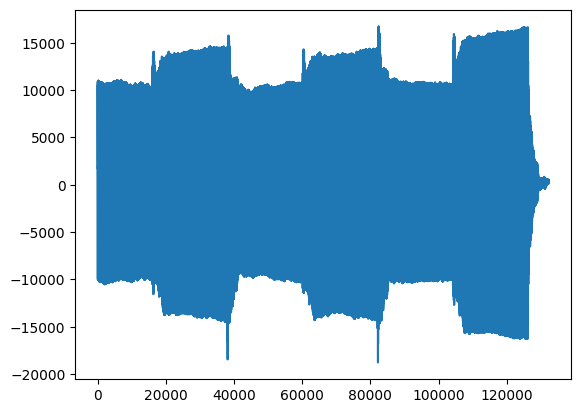

In [ ]:
data, srate = wav_data_x_sample_rate("recorded.wav")
b = find_beginning(data, int(DURATION), SAMPLE_RATE, FREQ1, FREQ2)
plt.plot(b)

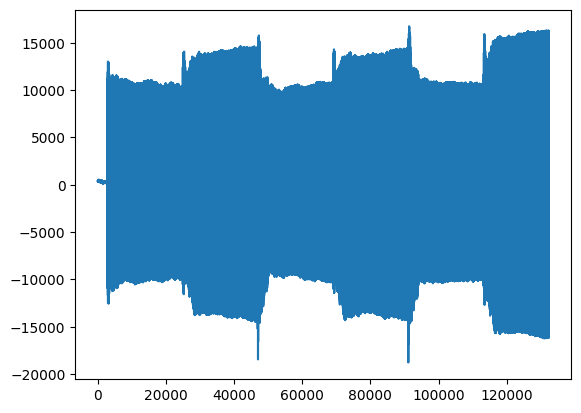

In [ ]:
plt.plot(b)

In [ ]:
write("processed", SAMPLE_RATE, b)

132096.0

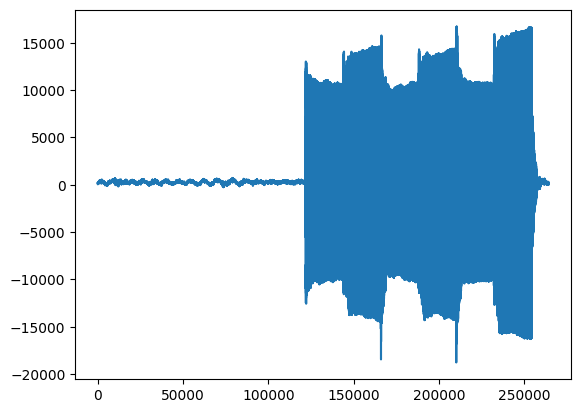

In [ ]:
plt.plot(data)
len(data) / 2

In [ ]:
a = [1]
a[:1]

[1]

In [ ]:
len(tone_ex) / 2

66150.0

In [ ]:
def decoder(data, sample_rate, duration, change_time, freq0, freq1):
    code = ""
    num = int(duration / change_time)
    signal = np.split(data, num)
    for i in range(num):
        yf = rfft(signal[i])
        xf = rfftfreq(len(signal[i]), 1 / sample_rate)
        xf, yf = fourier_pre_processing(xf, yf)
        abs_power = np.abs(yf)
        max_power = np.max(abs_power)
        index = np.where(abs_power == max_power)
        freq = xf[index]
        if np.isclose(freq, freq1, atol = 100):
            code += "1"
        if np.isclose(freq, freq0, atol = 100):
            code += "0"
    return code

In [ ]:
decoder(b, SAMPLE_RATE, len(TEXT) * CHANGE_TIME, CHANGE_TIME, FREQ1, FREQ2)


4
[2000.]
[2000.]
[1000.]
[1000.]


'1100'

In [ ]:
a = pre_processing(data, DURATION, SAMPLE_RATE)
yf = np.abs(rfft(a))
xf = rfftfreq(len(a), 1 / SAMPLE_RATE)
freq0_index, freq1_index = np.where(np.isclose(xf, 1000, atol = 1))[0][0], np.where(np.isclose(xf, 2000, atol = 1))[0][0]
freq_sum= yf[freq0_index] + yf[freq1_index]
freq_sum

224347023.06593513

In [ ]:
decoder()

0

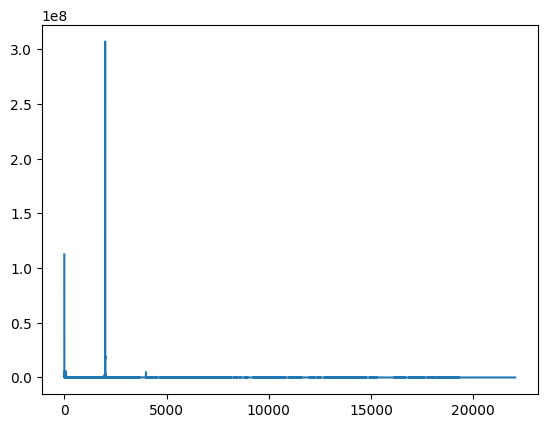

In [ ]:
yf = rfft(data)
xf = rfftfreq(len(data), 1 / SAMPLE_RATE)
start = 0
plt.plot(xf[start:], np.abs(yf[start:]))

In [ ]:
data, srate = wav_data_x_sample_rate("recorded.wav")
b = find_beginning(data, DURATION, SAMPLE_RATE, FREQ1, FREQ2)
len(data), len(tone_ex)

/tmp/ipykernel_12702/3470426258.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  while not math.isclose(max_freq, freq_sum, abs_tol = 20):


237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)
237837767.7213053 (63073659.0193435-27753397.976489168j)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
b = int(np.array(np.where(data > np.max(data) / 2))[0,0])
a = data[b:b + len(tone_ex)]

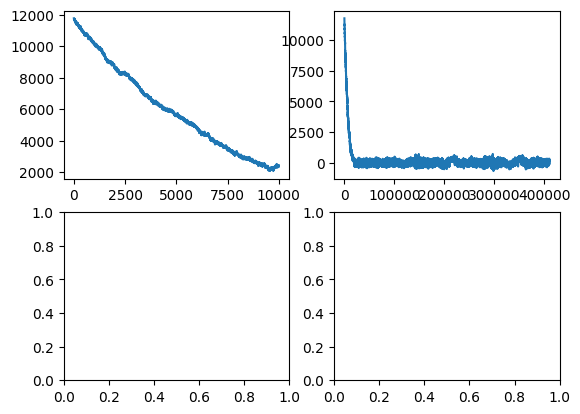

In [ ]:
figure, axis = plt.subplots(2, 2)
data = data[abs(data) > 100]
axis[0,0].plot(data[0:10000])
axis[0,1].plot(temp)

''

In [ ]:
_, a = generate_sine_wave(1000, 44100, 5)
a

array([ 0.        ,  0.14199432,  0.28111111, ..., -0.41453118,
       -0.28111111, -0.14199432])